# DAY 1

Here I am interpolating CT and SA to a regular grid, then compute the boyancy, boyancy gradient, I after that open the winddata to compute the windstress. Then I open the ADCP data and I compute the alongfront wind by taking the difference of the angle for the depth avereged current and the windstress

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from pathlib import Path
import cmocean as cmo
import numpy as np
import gsw
from pathlib import Path
from pyproj import Geod
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d



In [2]:
# Function to load ONE file
def load_files(filepath: str | Path) -> pd.DataFrame:
    """
    Read an SBE text export that has metadata lines before the real header.
    Returns a tidy DataFrame with an extra 'datetime' column.
    """
    filepath = Path(filepath)

    # detect how many metadata lines to skip ------------------
    with filepath.open('r', encoding='latin1') as f:
        for i, line in enumerate(f):
            if line.strip().startswith("Date") and "Time" in line:
                skiprows = i
                break

    # read the rest ------------------------------------------
    df = pd.read_csv(
        filepath,
        sep=r'\s+',                 # whitespace delimiter
        skiprows=skiprows,          # jump over metadata
        encoding='latin1'
    )

    # combine date/time to real datetime ----------------------
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['source']   = filepath.stem   # keep the filename → handy for legends
    df = df.iloc[1:]                # drop the first data row
    return df


# 2.  Load desired files

files = [
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\224_2025-05-06_07.35.09__to_Skagen_741601.txt", #Dag 1 
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-07_07.11.44_Skagen_to__741601.txt", # Halva dag 2
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\225_2025-05-07_07.11.44_Skagen_to_Skagen_741601.txt", # Hela dag 2
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-08_07.24.29_Skagen_to__741601.txt" #Dag 3
]
dfs = [load_files(f) for f in files]

# Concatenate if you just want one big table:
df_all = pd.concat(dfs, ignore_index=True)

In [3]:
df_all

,Date,Time,Latitude,Longitude,Course,Speed,Temp_SBE45,Cond_SBE45,Salinity_SBE45,SoundVel_SBE45,...,pH,Chlorophyll,Turbidity,pressure,flow_main,flow_SBE45,Phycocyanin,CDOM,datetime,source
0,2025.05.06,07:37:00,57.667360,11.782509,227.331050,11.000000,10.153903,2.439251,21.301802,1473.792397,...,9.061328,0.958452,1.984402,206.345250,8.967182,3.310180,1.031333,-0.015625,2025-05-06 07:37:00,224_2025-05-06_07.35.09__to_Skagen_741601
1,2025.05.06,07:38:00,57.665152,11.778037,226.105023,11.000000,10.168917,2.505584,21.929166,1474.605690,...,9.062532,0.852692,1.977557,206.427254,8.943592,3.302311,1.012083,-0.017500,2025-05-06 07:38:00,224_2025-05-06_07.35.09__to_Skagen_741601
2,2025.05.06,07:39:00,57.662873,11.773772,223.215103,11.000000,10.182814,2.569033,22.530538,1475.383397,...,9.064200,0.811377,1.896585,206.325303,8.978257,3.304303,0.981750,-0.018750,2025-05-06 07:39:00,224_2025-05-06_07.35.09__to_Skagen_741601
3,2025.05.06,07:40:00,57.660707,11.769391,234.350000,11.000000,10.144962,2.512420,22.009384,1474.613534,...,9.062676,0.790275,1.895693,199.694033,8.977371,3.320903,1.022583,-0.014375,2025-05-06 07:40:00,224_2025-05-06_07.35.09__to_Skagen_741601
4,2025.05.06,07:41:00,57.659370,11.764079,249.522831,11.000000,10.074745,2.594584,22.844819,1475.362052,...,9.063355,0.896750,1.961646,203.430771,8.952452,3.320804,1.133417,-0.017708,2025-05-06 07:41:00,224_2025-05-06_07.35.09__to_Skagen_741601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2025.05.06,15:20:00,57.709857,10.629703,303.970660,10.000000,10.769966,3.415120,30.350514,1486.951552,...,9.048560,0.630843,1.299025,194.917835,8.548326,3.202412,0.810576,-0.017394,2025-05-06 15:20:00,224_2025-05-06_07.35.09__to_Skagen_741601
464,2025.05.06,15:21:00,57.711511,10.625163,303.242280,10.000000,10.678016,3.410235,30.378640,1486.657190,...,9.048598,0.656364,1.296098,196.083626,8.543785,3.205035,0.823667,-0.014375,2025-05-06 15:21:00,224_2025-05-06_07.35.09__to_Skagen_741601
465,2025.05.06,15:22:00,57.712860,10.620621,292.098592,9.126761,10.516971,3.398860,30.400131,1486.105948,...,9.048800,0.626972,1.302539,198.171412,8.545778,3.201682,0.795667,-0.018750,2025-05-06 15:22:00,224_2025-05-06_07.35.09__to_Skagen_741601
466,2025.05.06,15:23:00,57.713594,10.615796,281.241218,9.000000,10.437086,3.388974,30.368640,1485.780845,...,9.049068,0.578992,1.337657,196.677604,8.553309,3.208853,0.810833,-0.017083,2025-05-06 15:23:00,224_2025-05-06_07.35.09__to_Skagen_741601


In [4]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Ensure datetime format
# df_all['datetime'] = pd.to_datetime(df_all['datetime'])

# # Set datetime as index
# df_all.set_index('datetime', inplace=True)

# # Get datetime range for title
# start_time = df_all.index.min().strftime('%Y-%m-%d %H:%M')
# end_time = df_all.index.max().strftime('%Y-%m-%d %H:%M')
# time_range_title = f'Data from {start_time} to {end_time}'

# # Create subplots
# fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# # Plot Temp_SBE45
# axes[0].plot(df_all.index, df_all['Temp_in_SBE38'], color='tab:blue')
# axes[0].set_title(f'Temp_in_SBE38 ({time_range_title})')
# axes[0].set_ylabel('°C')
# axes[0].grid(True)

# # Plot Salinity_SBE45
# axes[1].plot(df_all.index, df_all['Salinity_SBE45'], color='tab:green')
# axes[1].set_title(f'Salinity_SBE45 ({time_range_title})')
# axes[1].set_ylabel('PSU')
# axes[1].set_xlabel('Timestamp')
# axes[1].grid(True)

# plt.tight_layout()
# plt.show()


Remove/Interpolate the outlier in the transect from skagen to gbg, last day

In [5]:
# New way thats working
# There is one outlier in the temp data, I will flag it and then interpolate inbetween

# # flag outliers
# bad = df_all['Temp_in_SBE38'] > 100            # any value > 100 °C is impossible  
# df_all.loc[bad, 'Temp_in_SBE38'] = np.nan      # set those outliers to NaN

df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].mask(df_all['Temp_in_SBE38'] > 100)

# interpolate the gaps
df_all = df_all.set_index('datetime')              # make time the index  
df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].interpolate('time')  # linear fill in time  
df_all = df_all.reset_index()                      # restore datetime as a column

Get the sigma density and Cons. temp and abs. sal

In [6]:
# Convert everything to TEOS-10
SP  = df_all['Salinity_SBE45'].to_numpy()   # practical salinity is what we have in the dataset, will convert to Absolute sal
T   = df_all['Temp_in_SBE38'].to_numpy()    # in-situ temp (°C, ITS-90), will convert to Conservative T
p   = df_all['pressure'].to_numpy() / 100.0    # mbar → dbar  (1 dbar = 100 mbar)
lon = df_all['Longitude'].to_numpy()
lat = df_all['Latitude'].to_numpy()

SA = gsw.SA_from_SP(SP, p, lon, lat)    # absolute salinity
CT = gsw.CT_from_t(SA, T, p)            # conservative temp

# Store everything in the the dataset
df_all['SA'] = SA
df_all['CT'] = CT
df_all['press_db'] =p
df_all['sigma0'] = gsw.sigma0(SA, CT)       # potential density anomaly σθ

Interpolate the temp and salinity to the common grid before computing boyancy instead

In [7]:
#   Build cumulative distance 'dist'   (metres from first station)
from pyproj import Geod

# Constants
g = 9.81                    # Gravity (m/s²)
target_depth = 2.0          # Target depth for buoyancy analysis (m)
depth_window = 0.5          # Allowed variation around target depth (± m)
dx = 200                 # Regular horizontal resolution (m)
geod = Geod(ellps="WGS84")  # Geodesic calculator

# Step 1: Convert pressure to depth and filter around 2 m
df_all['Depth'] = -gsw.z_from_p(df_all['pressure'] / 100, df_all['Latitude'])
depth = df_all["Depth"].to_numpy()
mask = np.abs(depth - target_depth) <= depth_window
df_near_depth = df_all[mask].copy()
# Use the near-surface subset (df_near_depth) so Lon/Lat match SA & CT
lon = df_near_depth["Longitude"].to_numpy()
lat = df_near_depth["Latitude"].to_numpy()

# Great-circle segment length between every consecutive pair
_, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])   # metres

# Cumulative distance:  0, s₁, s₁+s₂, …
dist = np.concatenate(([0.0], np.cumsum(step)))

# ------------------------------------------------------------------
# 1.  Define the regular grid you’ll work on
# ------------------------------------------------------------------
dx    = 200                       # desired resolution [m]
d_reg = np.arange(0, dist[-1], dx)


# ------------------------------------------------------------
# 4′.  Build the common 200-m grid
# ------------------------------------------------------------
dx      = 200                           # m
d_reg   = np.arange(0, dist[-1], dx)    # 0, 200, 400, …

# ------------------------------------------------------------
# 5′.  Interpolate SA and CT to that grid
# ------------------------------------------------------------
SA_reg = interp1d(dist, SA, bounds_error=False, fill_value=np.nan)(d_reg)
CT_reg = interp1d(dist, CT, bounds_error=False, fill_value=np.nan)(d_reg)

# (optional) light smoothing of each tracer before using them
# SA_reg = gaussian_filter1d(SA_reg, sigma=2)
# CT_reg = gaussian_filter1d(CT_reg, sigma=2)

# ------------------------------------------------------------
# 6′.  Now do the thermodynamics on-grid
# ------------------------------------------------------------
sigma0_reg = gsw.sigma0(SA_reg, CT_reg)        # kg m-3 – 1000
rho_reg    = sigma0_reg + 1000.0
rho0       = np.nanmean(rho_reg)               # reference density

g        = 9.81                                # m s-2
b_reg    = g * (1 - rho_reg / rho0)

# ------------------------------------------------------------
# 7′.  Smooth & differentiate
# ------------------------------------------------------------

# ------------------------------------------------------------
# 7½.  Bundle every gridded field into one tidy DataFrame
# ------------------------------------------------------------

b_reg_smooth = gaussian_filter1d(b_reg, sigma=2)   # ~2 km
dbdx_reg     = np.gradient(b_reg_smooth, dx)       # ∂b/∂x on d_reg

df_dbdx = pd.DataFrame({
    "distance_m": d_reg,       # 0, 200, 400, …
    "SA"        : SA_reg,      # absolute salinity (g/kg)
    "CT"        : CT_reg,      # conservative temp (°C)
    "b"         : b_reg_smooth,# smoothed buoyancy (m/s²)
    "dbdx"      : dbdx_reg     # horizontal buoyancy gradient (s⁻²)
})

# ------------------------------------------------------------
# 8′.  (If needed) project the gradient back to each original station
# ------------------------------------------------------------
buoy_grad = np.interp(dist, d_reg, dbdx_reg, left=np.nan, right=np.nan)

df_clean = df_near_depth.copy()
df_clean["buoy_grad"] = buoy_grad

# Save in new dataset

df_dbdx["SA"] = SA_reg
df_dbdx["CT"] = CT_reg



In [8]:
df_dbdx

,distance_m,SA,CT,b,dbdx
0,0.0,21.436299,10.254032,0.027191,-3.672273e-06
1,200.0,21.782808,10.237889,0.026457,-4.747002e-06
2,400.0,22.127244,10.217610,0.025292,-5.873522e-06
3,600.0,22.462572,10.179162,0.024107,-5.263461e-06
4,800.0,22.553833,10.142087,0.023187,-3.674746e-06
...,...,...,...,...,...
632,126400.0,30.535629,10.363261,-0.037210,-8.408434e-07
633,126600.0,30.549541,10.350194,-0.037340,-4.978052e-07
634,126800.0,30.541956,10.353961,-0.037409,-2.449196e-07
635,127000.0,30.526885,10.370060,-0.037438,-9.672815e-08


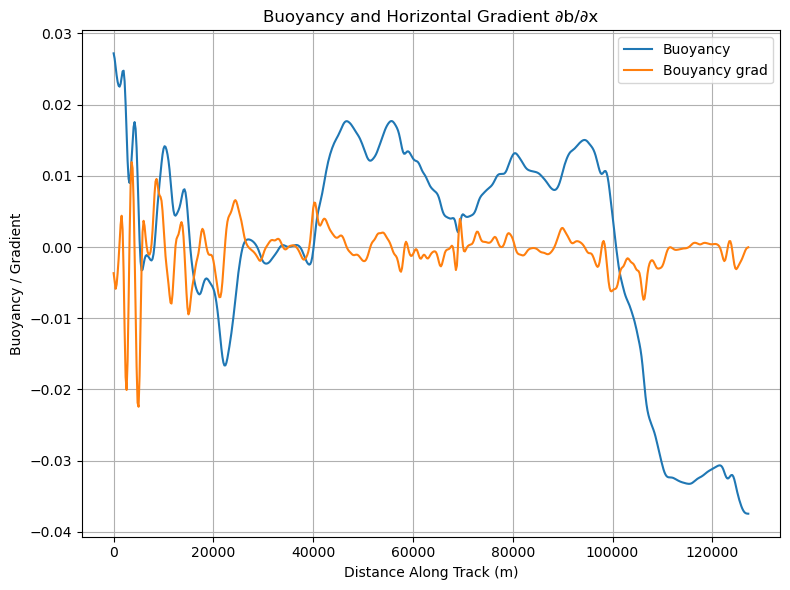

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(df_dbdx['distance_m'], df_dbdx['b'], label='Buoyancy')               # original buoyancy (irregular)
plt.plot(df_dbdx['distance_m'], df_dbdx['dbdx'] * 1e3, label='Bouyancy grad')          # regular grid
#plt.plot(d_reg, dbdx_reg * 1e3, label='∂b/∂x (×1e3)', color='green')

plt.xlabel('Distance Along Track (m)')
plt.ylabel('Buoyancy / Gradient')
plt.legend()
plt.title('Buoyancy and Horizontal Gradient ∂b/∂x')
plt.grid(True)
plt.tight_layout()
plt.show()


Open the weather data to compute the Ekman bouyancy flux (Dont mind the position data)

In [10]:
df_wind = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_weather.csv")
# df_pos = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_position.csv")

In [11]:
df_wind['ts'] = pd.to_datetime(df_wind['ts']).dt.round('1s')
# df_pos['ts'] = pd.to_datetime(df_pos['ts']).dt.round('1s')

# df = pd.merge(df_pos, df_wind, on='ts', how='inner')

In [12]:
df_wind = df_wind.rename(columns={'ts': 'Time'})
df_wind = df_wind.rename(columns={'longitude': 'Longitude'})
df_wind = df_wind.rename(columns={'latitude': 'Latitude'})

Compute windstress

In [13]:
# Get windstress

# ── 2.  vectorised air-density ρ_a(T, p, RH) ───────────────────────────
T   = df_wind['airtemp'].to_numpy(float)         # °C
P   = df_wind['airpressure'].to_numpy(float) * 100    # hPa → Pa
RH  = df_wind['humidity'].to_numpy(float) / 100     # %

Rd, Rv = 287.05, 461.5
es = 611.2 * np.exp((17.67 * T) / (T + 243.5))   # Pa (sat. vapour press.)
e  = RH * es                                     # Pa (actual vapour press.)
rho_air = (P - e) / (Rd * (T + 273.15)) + e / (Rv * (T + 273.15))

# ── 3.  wind-vector components (u, v) from speed + “from” direction ────
U     = df_wind['windspeed'].to_numpy(float)          # m s⁻¹
theta_wind = np.deg2rad(df_wind['winddir'].to_numpy(float))

u = -U * np.sin(theta_wind)      # eastward (+ = toward east)
v = -U * np.cos(theta_wind)      # northward (+ = toward north)

# ── 4.  constant drag coefficient & wind-stress components ─────────────
Cd   = 1.5e-3                                    # dimensionless
tau  = rho_air * Cd * U**2                       # magnitude  (N m⁻²)
tau_x = rho_air * Cd * U * u                     # eastward stress
tau_y = rho_air * Cd * U * v                     # northward stress

# store in DataFrame
df_wind['tau']   = tau
df_wind['tau_x'] = tau_x
df_wind['tau_y'] = tau_y
df_wind['theta_wind'] = theta_wind
df_wind['u_wind'] = u
df_wind['v_wind'] = v


# ── 5.  quick sanity print ─────────────────────────────────────────────
print(df_wind[['tau', 'tau_x', 'tau_y']].head())

        tau     tau_x     tau_y
0  0.021691 -0.004510 -0.021217
1  0.020434 -0.004597 -0.019910
2  0.018033  0.008466 -0.015922
3  0.011727 -0.001429 -0.011640
4  0.027085  0.001889 -0.027019


In [14]:
# --------------------------------------------------
# 0.  Ensure both data sets are time-sorted
# --------------------------------------------------
df_wind["datetime"] = pd.to_datetime(df_wind["Time"])
df_wind = df_wind.sort_values("datetime").reset_index(drop=True)

df_clean = df_near_depth.copy()                  # already filtered 2 ±0.5 m
df_clean["dist_m"] = dist                        # keep the mapping t ↔ x
df_clean = df_clean.sort_values("datetime")

# --------------------------------------------------
# 1.  Helper: time (ns)  →  distance (m)
# --------------------------------------------------
t_clean_ns = df_clean["datetime"].astype("int64").to_numpy()
x_clean    = df_clean["dist_m"].to_numpy()

time2dist = interp1d(t_clean_ns, x_clean,
                     bounds_error=False, fill_value=np.nan)

# --------------------------------------------------
# 2.  Interpolate wind variables straight to the 200-m grid
# --------------------------------------------------
t_wind_ns = df_wind["datetime"].astype("int64").to_numpy()
x_wind    = time2dist(t_wind_ns)                 # where each wind sample sits

wind_cols = ["tau_x", "tau_y", "tau", "theta_wind"]

for var in wind_cols:
    y_wind = df_wind[var].to_numpy()

    # sample wind onto YOUR regular grid
    y_reg  = np.interp(d_reg, x_wind, y_wind,
                       left=np.nan, right=np.nan)

    # store in the master table
    df_dbdx[var] = y_reg


In [15]:
df_dbdx.isna().sum()


distance_m    0
SA            0
CT            0
b             0
dbdx          0
tau_x         9
tau_y         9
tau           9
theta_wind    9
dtype: int64

In [16]:
df_dbdx.shape

(637, 9)

# get ADCP data to get the alongfront wind

In [17]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import pytz

# File path
file_path = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\adcp_data_6_maj.txt' # Day 1

# Read and clean raw data
raw = pd.read_csv(file_path, sep="\t", skiprows=12, engine="python")
raw = raw.map(lambda x: str(x).replace(",", "."))  # replace comma decimals
raw = raw.iloc[3:-3].reset_index(drop=True)

# Convert numeric columns
numeric_cols = raw.columns.drop(['    "FLat"', '    "FLon"', '    "LLat"', '    "LLon"'])
raw[numeric_cols] = raw[numeric_cols].astype(float)

# Extract ADCP velocities
east = raw[[f"Eas{'.'+str(i) if i else ''}" for i in range(10)]].to_numpy()
north = raw[[f"Nor{'.'+str(i) if i else ''}" for i in range(10)]].to_numpy()

# Build datetime list
t = [dt.datetime(2000+int(y), int(m), int(d), int(HH), int(MM), int(SS))
     for y, m, d, HH, MM, SS in raw[['YR','MO','DA','HH','MM','SS']].to_numpy()]

# Timezone correction (from UTC+2 → UTC)
local_tz = pytz.timezone('Europe/Stockholm')
t_localized = [local_tz.localize(time) for time in t]
t_utc = [time.astimezone(pytz.utc).replace(tzinfo=None) for time in t_localized]

# Create DataArrays
depth = np.arange(8, 8+4*10, 4)
east_da = xr.DataArray(east, dims=["time", "depth"], coords={"time": t_utc, "depth": depth}, name="east_velocity")
north_da = xr.DataArray(north, dims=["time", "depth"], coords={"time": t_utc, "depth": depth}, name="north_velocity")

# Latitude & longitude
lat = raw['    "FLat"'].astype(float)
lon = raw['    "FLon"'].astype(float)

# Build xarray dataset
ds = xr.merge([east_da, north_da])
ds = ds.where(np.abs(ds) < 500)          # remove spikes
ds = ds / 1000                           # mm/s → m/s
ds = ds.assign_coords(lat=("time", lat), lon=("time", lon))

# Final: align time ranges with df_clean/df_wind
start_time = pd.to_datetime(ds.time.values[0])
end_time = pd.to_datetime(ds.time.values[-1])
df_wind = df_wind[(df_wind['datetime'] >= start_time) & (df_wind['datetime'] <= end_time)].copy()
df_clean = df_clean[(df_clean['datetime'] >= start_time) & (df_clean['datetime'] <= end_time)].copy()

df_wind = df_wind.sort_values('datetime')
df_clean = df_clean.sort_values('datetime')


In [31]:
import numpy as np
from scipy.interpolate import interp1d

# --------------------------------------------------
# 1.  depth-average current  (m s-1)
# --------------------------------------------------
u_avg = ds["east_velocity"].mean(dim="depth")
v_avg = ds["north_velocity"].mean(dim="depth")

# filter out rows that still contain NaNs after the mean
mask_uv = np.isfinite(u_avg) & np.isfinite(v_avg)
t_adcp  = ds["time"].values[mask_uv]                 # np.datetime64[ns]
u_avg   = u_avg.values[mask_uv]
v_avg   = v_avg.values[mask_uv]

# --------------------------------------------------
# 2.  wind stress at the same moments                (N m-2)
# --------------------------------------------------
t_wind_ns = df_wind["datetime"].astype("int64").to_numpy()
tau_x_w   = df_wind["tau_x"].to_numpy()
tau_y_w   = df_wind["tau_y"].to_numpy()

interp_tx = interp1d(t_wind_ns, tau_x_w, bounds_error=False, fill_value=np.nan)
interp_ty = interp1d(t_wind_ns, tau_y_w, bounds_error=False, fill_value=np.nan)

tau_x_adcp = interp_tx(t_adcp.astype("int64"))
tau_y_adcp = interp_ty(t_adcp.astype("int64"))

# --------------------------------------------------
# 3.  angles and projections
# --------------------------------------------------
# |τ| and direction toward which the wind blows
tau_mag   = np.hypot(tau_x_adcp, tau_y_adcp)
theta_w   = np.arctan2(tau_y_adcp, tau_x_adcp)       # radians, −π…π

# current speed and direction (toward)
speed_cur = np.hypot(u_avg, v_avg)
theta_c   = np.arctan2(v_avg, u_avg)

delta_theta = np.angle(np.exp(1j * (theta_w - theta_c)))   # wrap to −π…π

# 3½.  Make the quality mask *before* the projection
# --------------------------------------------------
good_tau = (
    np.isfinite(tau_x_adcp) &
    np.isfinite(tau_y_adcp) &
    np.isfinite(u_avg)      &
    np.isfinite(v_avg)      &
    (speed_cur > 1e-4)      # avoid tiny speeds
)

# pre-allocate with NaN
tau_along_adcp = np.full_like(tau_mag, np.nan)
tau_cross_adcp = np.full_like(tau_mag, np.nan)

# only project where the data are good
tau_along_adcp[good_tau] = tau_mag[good_tau] * np.cos(delta_theta[good_tau])
tau_cross_adcp[good_tau] = tau_mag[good_tau] * np.sin(delta_theta[good_tau])


# --------------------------------------------------
# 4.  map ADCP time → along-track distance (metres)
# --------------------------------------------------
t_clean_ns = df_clean["datetime"].astype("int64").to_numpy()
x_clean    = df_clean["dist_m"].to_numpy()

time2dist = interp1d(t_clean_ns, x_clean,
                     bounds_error=False, fill_value=np.nan)

x_adcp = time2dist(t_adcp.astype("int64"))        # metres for each ADCP time

# --------------------------------------------------
# 5.  interpolate guarded τ‖ onto the 200-m grid
# --------------------------------------------------
# good_tau mask already built just above
# tau_along_adcp already filled with NaNs where data are bad

xp_good  = x_adcp[good_tau]          # distances that passed the mask
tau_good = tau_along_adcp[good_tau]  # their τ‖ values

tau_along_reg = np.full_like(d_reg, np.nan, dtype=float)  # start all NaN

if len(xp_good) >= 2:                # need at least two points for interp
    tau_along_reg = np.interp(
        d_reg, xp_good, tau_good,
        left=np.nan, right=np.nan
    )

    # (optional) blank out bins too far from a real ADCP point)
    max_gap = 3 * dx                 # e.g. 600 m
    nearest = np.abs(d_reg[:, None] - xp_good).min(axis=1)
    tau_along_reg[nearest > max_gap] = np.nan

df_dbdx["tau_along"] = tau_along_reg



In [32]:
Cp = 4000.0        # J kg-1 K-1
g  = 9.81
omega = 7.2921e-5
f = 2 * omega * np.sin(np.deg2rad(df_clean["Latitude"].mean()))

df_dbdx["alpha"]  = gsw.alpha(df_dbdx["SA"],
                              df_dbdx["CT"],
                              df_clean["press_db"].mean())     # 1 Pa ⇒ ~1 dbar


# mask: all inputs must be finite, and alpha must be > 0
mask_Q = (
    df_dbdx["dbdx"].notna()       &
    df_dbdx["tau_along"].notna()  &
    df_dbdx["alpha"].notna()      &
    (df_dbdx["alpha"] > 1e-6)
)

# start with a NaN-filled column
df_dbdx["Q_EBF"] = np.nan
df_dbdx.loc[mask_Q, "Q_EBF"] = -(
    df_dbdx.loc[mask_Q, "dbdx"] *
    df_dbdx.loc[mask_Q, "tau_along"]
) * (Cp / (df_dbdx.loc[mask_Q, "alpha"] * g * f))


In [33]:
print("Valid τ‖ bins :", df_dbdx["tau_along"].notna().sum(),
      "/", len(df_dbdx))
print("Valid Q_EBF bins:", df_dbdx["Q_EBF"].notna().sum(),
      "/", len(df_dbdx))


Valid τ‖ bins : 276 / 637
Valid Q_EBF bins: 276 / 637


In [40]:
# ------------------------------------------------------------
# depth-avg current (u_avg, v_avg) already built at t_adcp times
# x_adcp             = distance (m) for each ADCP profile
# good_uv            = True where u & v are finite and speed > 0
# ------------------------------------------------------------

xp_good  = x_adcp[good_uv]                # positions with real data
u_good   = u_avg[good_uv]
v_good   = v_avg[good_uv]

# --- 1. start output arrays as all-NaN -----------------------
u_reg = np.full_like(d_reg, np.nan, dtype=float)
v_reg = np.full_like(d_reg, np.nan, dtype=float)

# --- 2. interpolate only if ≥2 good points ------------------
if xp_good.size >= 2:
    u_reg = np.interp(d_reg, xp_good, u_good,
                      left=np.nan, right=np.nan)
    v_reg = np.interp(d_reg, xp_good, v_good,
                      left=np.nan, right=np.nan)

    # --- 3. blank out bins that are too far from any ADCP fix
    max_gap = 3 * dx           # e.g. 600 m; choose what you trust
    nearest = np.abs(d_reg[:, None] - xp_good).min(axis=1)
    far_mask = nearest > max_gap
    u_reg[far_mask] = np.nan
    v_reg[far_mask] = np.nan

# --- 4. store only the guarded fields -----------------------
df_dbdx["u_cur"]      = u_reg
df_dbdx["v_cur"]      = v_reg
df_dbdx["speed_cur"]  = np.hypot(u_reg, v_reg)
df_dbdx["theta_cur"]  = (np.degrees(np.arctan2(v_reg, u_reg)) + 360) % 360


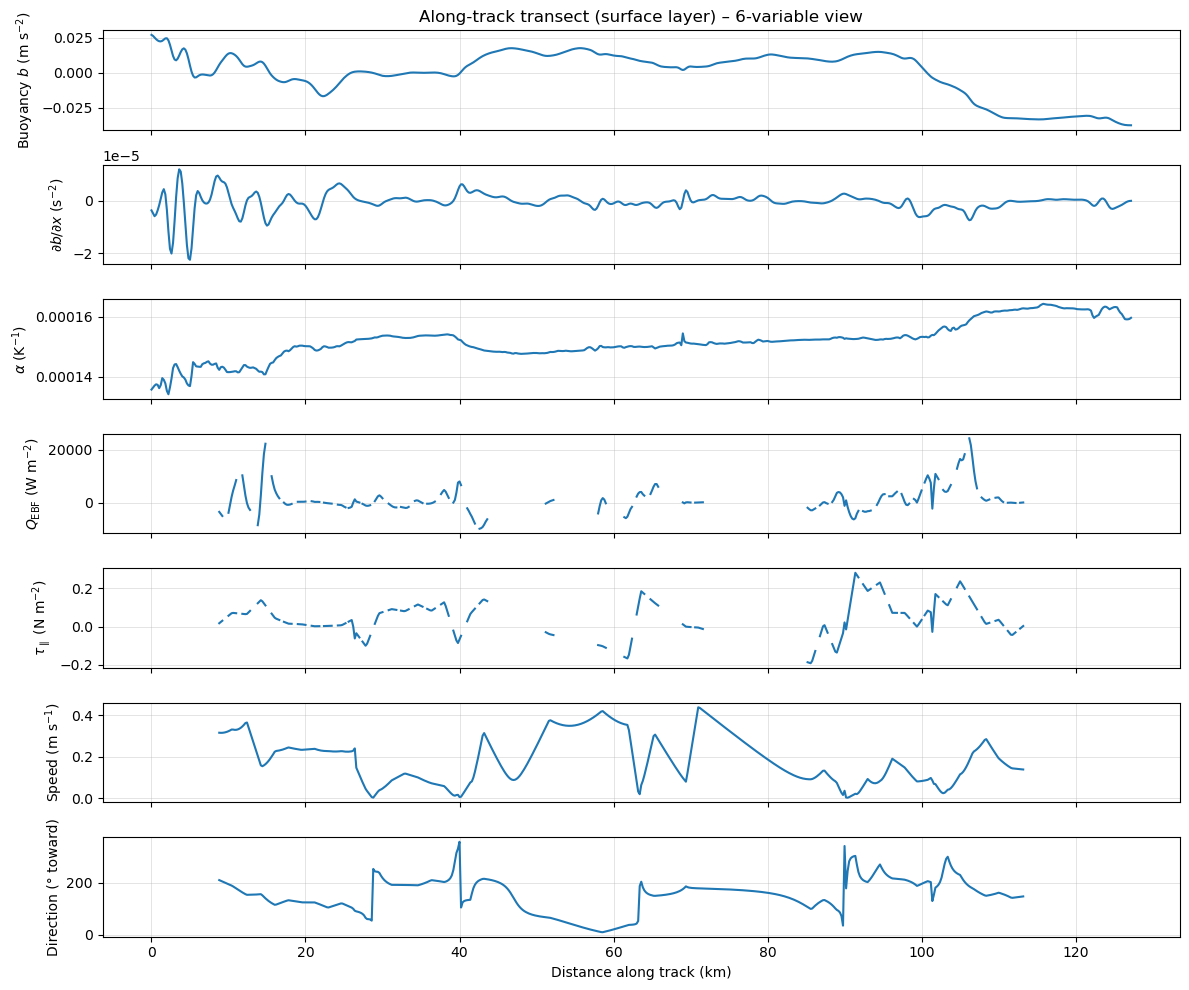

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ──────────────────────────────────────────────────────────────
# 0.  Make sure every variable you need is in df_dbdx
#     (depth-avg current speed might still be missing)
# ──────────────────────────────────────────────────────────────
# ------------------------------------------------------------
# depth-average current is u_avg, v_avg  |  positions are x_adcp
# ------------------------------------------------------------
xp_good  = x_adcp[good_uv]                # positions with real data
u_good   = u_avg[good_uv]
v_good   = v_avg[good_uv]

u_reg = np.full_like(d_reg, np.nan, dtype=float)
v_reg = np.full_like(d_reg, np.nan, dtype=float)

if xp_good.size >= 2:                     # need at least 2 real points
    u_reg = np.interp(d_reg, xp_good, u_good,
                      left=np.nan, right=np.nan)
    v_reg = np.interp(d_reg, xp_good, v_good,
                      left=np.nan, right=np.nan)

    # OPTIONAL: blank out bins farther than 3·dx (600 m here) from data
    max_gap = 3 * dx
    nearest = np.abs(d_reg[:, None] - xp_good).min(axis=1)
    far_mask = nearest > max_gap
    u_reg[far_mask] = np.nan
    v_reg[far_mask] = np.nan

# store vetted current fields
df_dbdx["u_cur"]      = u_reg
df_dbdx["v_cur"]      = v_reg
df_dbdx["speed_cur"]  = np.hypot(u_reg, v_reg)
df_dbdx["theta_cur"]  = (np.degrees(np.arctan2(v_reg, u_reg)) + 360) % 360


# ──────────────────────────────────────────────────────────────
# 1.  What we want to plot, in order top → bottom
# ──────────────────────────────────────────────────────────────
vars_to_plot = ["b", "dbdx", "alpha", "Q_EBF", "tau_along",
                "speed_cur", "theta_cur"]
ylabs = [ "Buoyancy $b$ (m s$^{-2}$)",
          r"$\partial b/\partial x$ (s$^{-2}$)",
          r"$\alpha$ (K$^{-1}$)",
          r"$Q_{\mathrm{EBF}}$ (W m$^{-2}$)",
          r"$\tau_{\parallel}$ (N m$^{-2}$)",
          "Speed (m s$^{-1}$)",
          "Direction (° toward)" ]


# ──────────────────────────────────────────────────────────────
# 2.  Plot
# ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(len(vars_to_plot), 1,
                         figsize=(12, 10), sharex=True)

x_km = df_dbdx["distance_m"] / 1000.0

for ax, col, lab in zip(axes, vars_to_plot, ylabs):
    ax.plot(x_km, df_dbdx[col])
    ax.set_ylabel(lab)
    ax.grid(True, lw=0.4, alpha=0.6)

axes[0].set_title("Along-track transect (surface layer) – 6-variable view")
axes[-1].set_xlabel("Distance along track (km)")
plt.tight_layout()
plt.show()


In [37]:
df_dbdx['Q_EBF'].describe()

count      276.000000
mean      1265.796673
std       5045.565415
min      -9892.617921
25%      -1089.973992
50%        187.797907
75%       2946.462177
max      24235.398360
Name: Q_EBF, dtype: float64

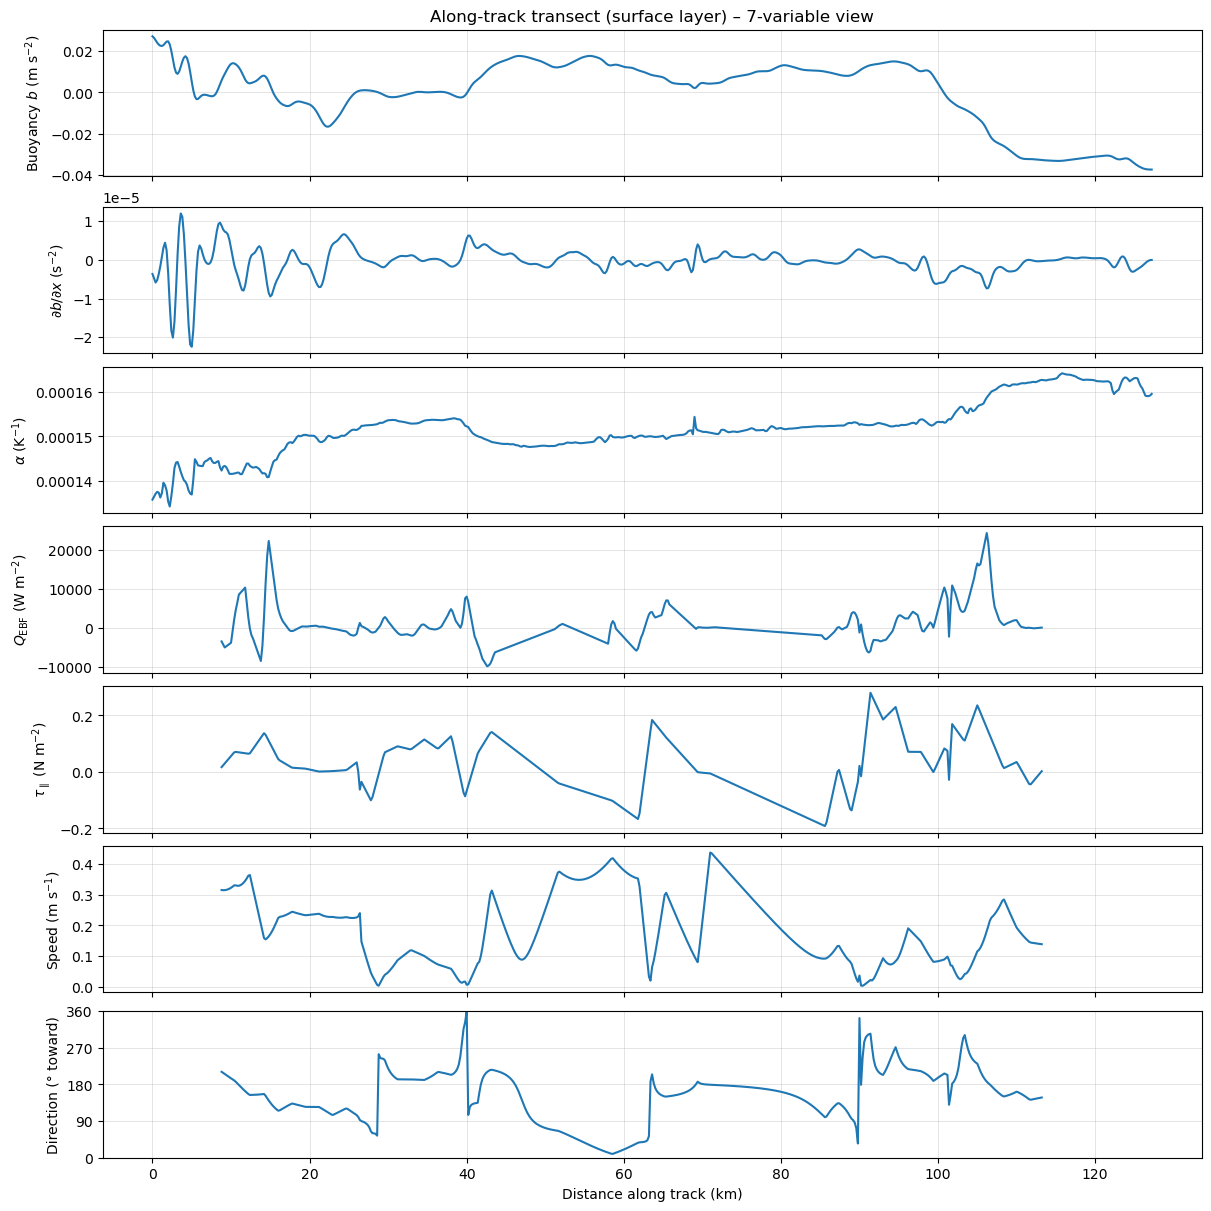

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ──────────────────────────────────────────────────────────────
# 0.  Put vetted depth-avg current on the 200 m grid
# ──────────────────────────────────────────────────────────────
if "speed_cur" not in df_dbdx.columns:

    # guard: only proceed if x_adcp and good_uv already exist
    assert "x_adcp" in globals() and "good_uv" in globals(), \
        "Run the ADCP section first so x_adcp and good_uv exist"

    xp_good = x_adcp[good_uv]
    u_good  = u_avg[good_uv]
    v_good  = v_avg[good_uv]

    u_reg = np.full_like(d_reg, np.nan, dtype=float)
    v_reg = np.full_like(d_reg, np.nan, dtype=float)

    if xp_good.size >= 2:
        u_reg = np.interp(d_reg, xp_good, u_good,
                          left=np.nan, right=np.nan)
        v_reg = np.interp(d_reg, xp_good, v_good,
                          left=np.nan, right=np.nan)

        # blank out bins farther than 3·dx (600 m) from any ADCP profile
        max_gap = 3 * dx
        nearest = np.abs(d_reg[:, None] - xp_good).min(axis=1)
        far_mask = nearest > max_gap
        u_reg[far_mask] = np.nan
        v_reg[far_mask] = np.nan

    df_dbdx["u_cur"]      = u_reg
    df_dbdx["v_cur"]      = v_reg
    df_dbdx["speed_cur"]  = np.hypot(u_reg, v_reg)
    df_dbdx["theta_cur"]  = (np.degrees(np.arctan2(v_reg, u_reg)) + 360) % 360


# ──────────────────────────────────────────────────────────────
# 1.  Variables & labels (7 panels)
# ──────────────────────────────────────────────────────────────
vars_to_plot = ["b", "dbdx", "alpha", "Q_EBF",
                "tau_along", "speed_cur", "theta_cur"]
ylabs = ["Buoyancy $b$ (m s$^{-2}$)",
         r"$\partial b/\partial x$ (s$^{-2}$)",
         r"$\alpha$ (K$^{-1}$)",
         r"$Q_{\mathrm{EBF}}$ (W m$^{-2}$)",
         r"$\tau_{\parallel}$ (N m$^{-2}$)",
         "Speed (m s$^{-1}$)",
         "Direction (° toward)"]

# ──────────────────────────────────────────────────────────────
# 2.  Plot
# ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(len(vars_to_plot), 1,
                         figsize=(12, 12), sharex=True,
                         constrained_layout=True)

x_km = df_dbdx["distance_m"] / 1000.0

for ax, col, lab in zip(axes, vars_to_plot, ylabs):
    mask = df_dbdx[col].notna()          # plot only valid bins
    ax.plot(x_km[mask], df_dbdx[col][mask])
    ax.set_ylabel(lab)
    ax.grid(True, lw=0.4, alpha=0.6)

# keep the direction panel intuitive
axes[-1].set_ylim(0, 360)
axes[-1].set_yticks(np.arange(0, 361, 90))

axes[0].set_title("Along-track transect (surface layer) – 7-variable view")
axes[-1].set_xlabel("Distance along track (km)")
plt.show()
